In this notebook we want to explore the validity of the data. To do so, we first load the forecast data:

In [1]:
import pandas as pd

reverse_station_mapping = {
    433: 10384, 2667: 10513, 3379: 10865, 1443: 10803, 
    5906: 10729, 2522: 10727, 4104: 10776, 1270: 10554, 
    5419: 10555
}

valid_stations = [
    reverse_station_mapping[station] for station in [433, 1270, 1443, 2667, 3379, 4104, 5906]
]

df = pd.read_csv("/Users/fohlen/Downloads/export_2024-11-08/merged.csv")
df = df[df["station_id"].isin(valid_stations)]
df["recorded_at"] = pd.to_datetime(df["recorded_at"])
df["forecast_time"] = pd.to_datetime(df["forecast_time"])
df.head()

,recorded_at,station_id,forecast_time,parameter,value
0,2024-05-12 15:00:17.390012,10513,2024-05-12 15:00:00,precipitation_height_significant_weather_last_1h,0.0
1,2024-05-12 15:00:17.390012,10513,2024-05-12 16:00:00,precipitation_height_significant_weather_last_1h,0.0
2,2024-05-12 15:00:17.390012,10513,2024-05-12 17:00:00,precipitation_height_significant_weather_last_1h,0.0
3,2024-05-12 15:00:17.390012,10513,2024-05-12 18:00:00,precipitation_height_significant_weather_last_1h,0.0
4,2024-05-12 15:00:17.390012,10513,2024-05-12 19:00:00,precipitation_height_significant_weather_last_1h,0.0


We check that the data hasn't been corrupted:

In [2]:
df.isnull().sum(axis = 0)

recorded_at      0
station_id       0
forecast_time    0
parameter        0
value            0
dtype: int64

When was this dataset recorded?

In [3]:
min_recorded = df.recorded_at.min()
print(min_recorded, df.forecast_time.max())

2024-05-11 15:02:31.830845 2024-11-18 14:00:00


We should the forecast to exactly 6 months:

In [4]:
end_date = min_recorded + pd.DateOffset(months=6)
df = df[df["forecast_time"] < end_date]

Next up, we want to decompose this dataset, we want to verify that the data is complete, specifically we have the following expectations:

- we measured 2 variables
- we measured across 7 stations
- 24 forecasts are measured daily (one per hour)
- each forecast contains 240 values (+240 hours into the future)
- 6 months were measured, which is 182,5 days

This multiplies out to $2*7*24*240*182,5 = 14716800$. These are all assumptions we can test to make sure out data is valid:

In [5]:
print(df["station_id"].unique())

assert len(df["parameter"].unique().tolist()) == 2
assert len(df["station_id"].unique().tolist()) == 7

print(len(df))
print(len(df) / 14716800)
# assert len(df) == 14716800

[10513 10776 10803 10554 10865 10384 10729]
14419142
0.9797742715807785


It appears this assertion doesn't hold, we are off by 0.01%, which is acceptable. Next up, we can check if the weather looks sensible. To do so, we plot the date on the $x$ axis, and the temperature on the $y$ axis. We also want to convert the temperature from Kelvin to Celsius first:

In [6]:
temperature_df = df[df["parameter"] == "temperature_air_mean_200"].copy()
temperature_df["temp_c"] = temperature_df.value.astype(float) - 273.15

We want to see wether temperature is normally distributed:

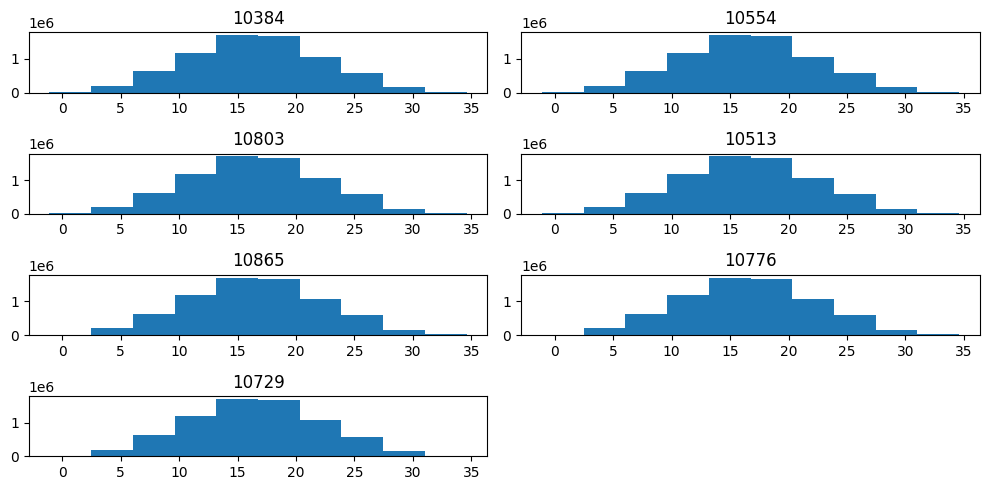

In [7]:
import matplotlib.pyplot as plt
from itertools import chain

def flatten(list_of_lists):
    "Flatten one level of nesting."
    return chain.from_iterable(list_of_lists)


fig, axs = plt.subplots(4, 2, figsize=(10, 5))

for index, (ax, station_id) in enumerate(zip(flatten(axs.tolist()), valid_stations)):
    ax.hist(temperature_df["temp_c"])
    ax.set_title(station_id)

axs[3, 1].remove()

plt.tight_layout()
plt.show()

We can plot the average forecasted temperate per station per day:

In [8]:
from collections import defaultdict

temp_forecasts = defaultdict(list)

for station_id in valid_stations:
    station_rows = temperature_df[temperature_df["station_id"] == station_id]

    for index, group in station_rows.groupby(station_rows.forecast_time.dt.dayofyear):
        temp_c = group.temp_c.mean()
        temp_forecasts[station_id].append(temp_c)

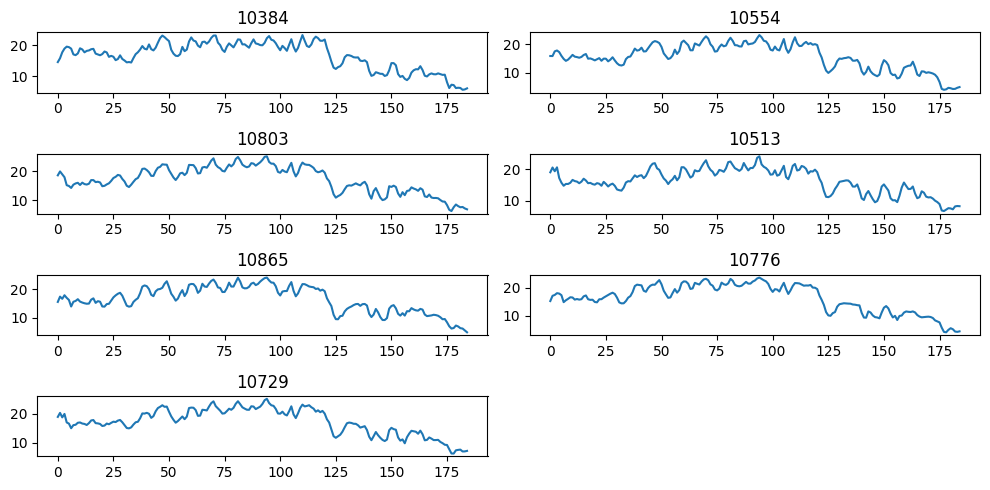

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(10, 5))

for index, (ax, station_id) in enumerate(zip(flatten(axs.tolist()), valid_stations)):
    ax.plot(temp_forecasts[station_id])
    ax.set_title(station_id)

axs[3, 1].remove()

plt.tight_layout()
plt.show()

In [11]:
from statistics import stdev

for station_id in valid_stations:
    print(station_id, stdev(temp_forecasts[station_id]))

10384 4.509208909702954
10554 4.590183487772366
10803 4.493211985730206
10513 3.938263129851862
10865 4.700070882225085
10776 5.015912335026783
10729 4.569915621456771
